# Controlled Oscillator

In the simple harmonic oscillator example, the frequency of the oscillation had to be specified as part of the network structure and could not be changed as the network was running. This example demonstrates how the NEF can be used to construct a controllable oscillator, in which the frequency of the oscillation can be controlled with an additional input signal to the network.

From the simple oscillator example, the neural equivalent of the input and feedback matrices can be computed as:
$$
\begin{align}
    \mathbf{A}' &= \tau\mathbf{A} + \mathbf{I} \\
    &= \tau\begin{bmatrix}
               0 && \omega \\
               -\omega && 0
           \end{bmatrix} + \mathbf{I} \\
    &= \begin{bmatrix}
           1 && \tau\cdot\omega \\
           -\tau\cdot\omega && 1
       \end{bmatrix}
\end{align}
$$

In an NEF network, the function the feedback is computing is state vector $x$ multiplied by the neural feedback matrix $\mathbf{A}'$:
$$
\begin{align}
    f_{fdbk}(x) &= \mathbf{A}'x \\
    &= \begin{bmatrix}
           1 && \tau\cdot\omega  \\
           -\tau\cdot\omega  && 1
       \end{bmatrix}x
\end{align}
$$

Since we want the speed of the oscillation to be a function of a provided input frequency $f$, we can use the substitution $\omega = 2\pi f$ to redefined the neural feedback function as a function of both $x$ and $f$:
$$
\begin{align}
    f_{fdbk}(x, f) &= \mathbf{A}'x \\
    &= \begin{bmatrix}
           1 && \tau \cdot 2\pi f  \\
           -\tau \cdot 2\pi f  && 1
       \end{bmatrix}x\\
    &= \begin{bmatrix}
           x_0 + \tau \cdot 2\pi f \cdot x_1 \\
           x_1 -\tau \cdot 2\pi f \cdot x_0
       \end{bmatrix}
\end{align}
$$

In the NEF, all variables used in the computation of a function have to be represented in the same neural population. In order to do this for the controlled oscillator, a 3-dimensional neural population is used, with the first two dimensions representing $x_0$ and $x_1$ respectively, and the last dimension ($x_2$) representing $f$. In doing this, the feedback function has to be modified slightly to account for the additional third dimension. Note that the last row of the feedback function is $0$ as the feedback should not have any effect on the representation of the speed state vector.
$$
\begin{align}
    f_{fdbk}(x)
    &= \begin{bmatrix}
           x_0 + \tau \cdot 2\pi \cdot x_2 \cdot x_1 \\
           x_1 -\tau \cdot 2\pi \cdot x_2 \cdot x_0 \\
           0
       \end{bmatrix}
\end{align}
$$

Because all state variables are being represented by the neural ensemble, we generally want to keep the variables within the unit sphere. If $x_0 = x_1 = x_2$, a point on the surface of the unit sphere is when $x_0 = x_1 = x_2 = \frac{1}{\sqrt{3}}$. Thus, the frequency input to the oscillator should be scaled by $\frac{1}{\sqrt{3}}$, and the feedback function has to be modified to take this into account:
$$
\begin{align}
    f_{fdbk}(x)
    &= \begin{bmatrix}
           x_0 + \tau \cdot 2\pi \cdot x_2 \cdot \sqrt{3} \cdot x_1 \\
           x_1 -\tau \cdot 2\pi \cdot x_2 \cdot \sqrt{3}  \cdot x_0 \\
           0
       \end{bmatrix}
\end{align}
$$

With these modifications, as long as the frequency input, $f$, is within $[-1, 1]$ Hz, $x_2$ should be within the desired range of $[-\frac{1}{\sqrt{3}}, \frac{1}{\sqrt{3}}]$. If you want to have a larger oscillation frequency, adapt this scaling factor appropriately.

## Step 1: Set up the Python Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import HTML

import nengo
from nengo.processes import Piecewise

import nengo_fpga
from nengo_fpga.networks import FpgaPesEnsembleNetwork

from anim_utils import make_anim_controlled_osc

## Step 2: Choose an FPGA Device

Define the FPGA device on which the remote FpgaPesEnsembleNetwork will run. This name corresponds with the name in your `fpga_config` file. Recall that in the `fpga_config` file, device names are identified by the square brackets (e.g., **[de1]** or **[pynq]**). The names defined in your configuration file might differ from the example below. Here, the device **de1** is being used.

In [2]:
board = 'de1'  # Change this to your desired device name

## Step 3: Create the Impulse Input for the Model
Using a piecewise step function, a 100ms impulse is generated as the "kick" signal. The frequency input to the oscillator is also generated using a piecewise step function. For the first 2 seconds of the simulation, the oscillator is set to 1Hz, followed by 0.5Hz in the next 2 seconds, then stationary, then 0.5Hz and subsequently 1Hz in the reverse direction.

In [3]:
model = nengo.Network(label='Controlled Oscillator')
# Create the kick function for input
with model:
    kick_node = nengo.Node(
        Piecewise({
            0: [1, 0, 0],
            0.1: [0, 0, 0]
        }))

    freq_node = nengo.Node(
        Piecewise({
            0: 1,
            2: 0.5,
            4: 0,
            6: -0.5,
            8: -1
        }))

## Step 4: Create the FPGA Ensemble

Create a remote FPGA neural ensemble (`FpgaPesEnsembleNetwork`) using the board defined above, 500 neurons, 3 dimensions, and with no learning rate. We will also specify the recurrent connection here.

In [4]:
tau = 0.1  # Synaptic time constant (s)
freq = 1  # Oscillation frequency (Hz)
freq_scale = np.sqrt(3)  # Frequency input scaling factor

with model:
    # Remote FPGA neural ensemble
    fpga_ens = FpgaPesEnsembleNetwork(
        board,  # The board to use (from above)
        n_neurons=500,  # The number of neurons to use in the ensemble
        dimensions=3,  # 3 dimensions
        learning_rate=0,  # No learning for this example
        feedback=1  # Activate the recurrent connection
    )

    # Setting `feedback=1` creates a `feedback` connection object
    # with the identity transform. To implement the oscillator, it
    # is necessary to set the transform on the feedback connection
    # using .transform.
    fpga_ens.feedback.synapse = tau  # `nengo.LowPass(tau)`

    # Define the feedback function
    def func_fdbk(x):
        # These are the three variables represented by the ensemble
        x0, x1, x2 = x
        return [x0 + tau * 2 * np.pi * x2 * freq_scale * x1,
                x1 - tau * 2 * np.pi * x2 * freq_scale * x0,
                0]
    # Assign the feedback function to the feedback connection
    fpga_ens.feedback.function = func_fdbk

## Step 5: Connect Everything Together
The recurrent connection is housed on the FPGA device and is created as part of the `FpgaPesEnsembleNetwork` object, so the connections that needs to be made are from the input nodes (for the impulse input and the frequency control) to the FPGA ensemble.

In [5]:
with model:
    # Connect the stimulus
    nengo.Connection(kick_node, fpga_ens.input,
                     synapse=tau, transform=1)

    # Connect the frequency input. Note the scaling factor used to
    # keep the represented values in the unit sphere
    nengo.Connection(freq_node, fpga_ens.input[2],
                     transform=1.0 / freq_scale)

## Step 6: Add Probes to Collect Data

In [6]:
with model:
    # The frequency input
    freq_p = nengo.Probe(freq_node)

    # The output from the FPGA ensemble
    # (filtered with a 10ms post-synaptic filter)
    output_p = nengo.Probe(fpga_ens.output, synapse=0.01)

## Step 7: Run the Model

In [7]:
with nengo_fpga.Simulator(model) as sim:
    sim.run(10)

## Step 8: Plot the Results

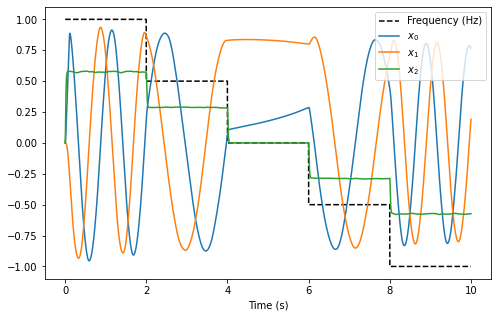

In [8]:
def plot_results():
    plt.figure(figsize=(8, 5))
    plt.plot(sim.trange(), sim.data[freq_p], 'k--')
    plt.plot(sim.trange(), sim.data[output_p])
    plt.legend(['Frequency (Hz)', '$x_0$', '$x_1$', '$x_2$'], loc='upper right')
    plt.xlabel('Time (s)');


plot_results()

The plot above shows that the interaction of all three dimensions of the oscillator cause the decoded output of the oscillator to exhibit the desired controlled oscillatory behaviour.

From the plot, it can be seen that for each 2 second block, the oscillation frequency is approximately 1Hz, 0.5Hz, somewhat stationary, 0.5Hz in the reverse direction, and 1Hz in the reverse direction.

While a static plot is somewhat informative, the behaviour of the oscillator becomes more apparent by plotting the first dimension of the output against the second dimension of the output. To make the behaviour more striking, the code below animates the 2-dimensional plot, with an additional plot to indicate the current frequency input. It may take a moment to generate the animation.

In [9]:
def make_anim():
    _, ax, ax2, anim = make_anim_controlled_osc(sim.data[output_p][:, 0],
                                                sim.data[output_p][:, 1],
                                                sim.data[freq_p])
    ax.set_title('Oscillator')
    ax2.set_title('Speed (Hz)')
    return anim


HTML(make_anim().to_html5_video())

## Step 9: Spiking Neurons

The plots above demonstrate the results of a controlled oscillator implemented in a network of non-spiking rectified linear neurons. The network can also be simulated using spiking neurons to illustrate the similarities and differences between a spiking and a non-spiking network.

Below, we configure the FPGA neural ensemble to use spiking neurons, run the simulation, and plot the results.

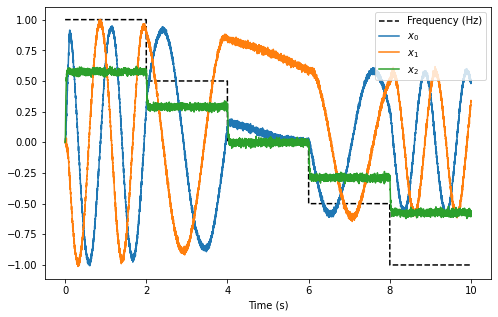

In [10]:
with model:
    fpga_ens.ensemble.neuron_type = nengo.SpikingRectifiedLinear()

with nengo_fpga.Simulator(model) as sim:
    sim.run(10)
plot_results()

In [11]:
HTML(make_anim().to_html5_video())

The plots above show that with spiking neurons, the output of the network is, expectedly, more noisy (less precise) than the results of the non-spiking network. However, despite this, the oscillator network in its current configuration is stable even with the spikes adding additional noise into the system.

It should be noted that the output of the spiking network differs from the output of the non-spiking network because the network parameters are regenerated (randomized) when a new Nengo simulation is created.

## Step 10: Experiment!

Try playing around with the number of neurons in the FPGA ensemble as well as the synaptic time constant (`tau`) to see how it effects performance (e.g., observe how changing these numbers affect the stability of the oscillator)! Additionally, try modifying the oscillation frequency input and make the appropriate changes to the scaling factor to see if they have the desired effect. You can also change the simulation time and see how long the oscillator is stable for!

Perform these experiments for both the non-spiking and spiking networks, and observe how the additional noise introduced by the spikes affect the performance of the network with relation to the various network and oscillator parameters.